In [1]:
import sys
import keras
sys.version
print(keras.__version__)

Using TensorFlow backend.


2.2.0


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras_applications.mobilenet import MobileNet
%matplotlib inline

In [67]:
# check gpu resources
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

In [5]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1" 

In [25]:
# count the number of objects from .xml annotation 
import xml.etree.ElementTree as ET

def parse_xml_num_object(ann_dir, img_dir):
    all_imgs = []
    for ann in sorted(os.listdir(ann_dir)):
        img = {'object': []}
        tree = ET.parse(ann_dir + ann)
        num = 0
        for elem in tree.iter():
            if 'filename' in elem.tag:
                img['filename'] = img_dir + elem.text
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag:
                num += 1
        img['obj_num'] = num
        if num > 1:      # only train on multi-object images (fine-tuning)
            all_imgs += [img]
    return all_imgs

In [26]:
# generate all_imgs (array), each instance is a dictionary
all_imgs = []
for i in range(0, 100):
    image_path = './UECFOOD100_JS/' + str(i+1) + '/'
    annot_path = './UECFOOD100_JS/' + str(i+1) + '/' + '/annotations_new/'

    folder_imgs = parse_xml_num_object(annot_path, image_path)
    all_imgs.extend(folder_imgs)
print(np.array(all_imgs).shape)

(2795,)


In [27]:
from keras.utils import Sequence

class CounterBatchGenerator(Sequence):
    def __init__(self, images,
                 config,
                 shuffle=True,
                 jitter=True,
                 norm=None):
        self.generator = None

        self.images = images
        self.config = config

        self.shuffle = shuffle
        self.jitter = jitter
        self.norm = norm      

        if shuffle: 
            np.random.shuffle(self.images)

    def __len__(self):
        return int(np.ceil(float(len(self.images)) / self.config['BATCH_SIZE']))

    def num_classes(self):
        return len(self.config['LABELS'])

    def size(self):
        return len(self.images)

    def load_image(self, i):
        return cv2.imread(self.images[i]['filename'])

    def __getitem__(self, idx):
        l_bound = idx * self.config['BATCH_SIZE']
        r_bound = (idx + 1) * self.config['BATCH_SIZE']

        if r_bound > len(self.images):
            r_bound = len(self.images)
            l_bound = r_bound - self.config['BATCH_SIZE']

        instance_count = 0

        x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_H'], self.config['IMAGE_W'], 3))  # input images
        y_batch = np.zeros((r_bound - l_bound, 1)).astype(int)  # desired network output

        for train_instance in self.images[l_bound:r_bound]:
            # augment input image and fix object's position and size
            img, obj_num = self.aug_image(train_instance, jitter=self.jitter)
            
            # assign ground truth obj_num to y_batch
            y_batch[instance_count, 0] = obj_num
            
            # assign input image to x_batch
            if self.norm != None:
                x_batch[instance_count] = self.norm(img)
            else:
                # plot number of objects on image to check if the code is right
                cv2.putText(img[:, :, ::-1], str(y_batch[instance_count, 0]), (100, 100), 0, 1, (255, 0, 0), 2)
                x_batch[instance_count] = img

            # increase instance counter in current batch
            instance_count += 1

        return [x_batch], y_batch

    def on_epoch_end(self):
        if self.shuffle: np.random.shuffle(self.images)

    def aug_image(self, train_instance, jitter):
        image_name = train_instance['filename']
        image = cv2.imread(image_name)

        if image is None: 
            print('Warning: Cannot find ', image_name)
        
        # resize the image to standard size
        image = cv2.resize(image, (self.config['IMAGE_H'], self.config['IMAGE_W']))
        image = image[:, :, ::-1]

        return image, train_instance['obj_num']

In [54]:
# generate CounterBatchGenerator for training and validation set
def read_category():
    category = []
    with open('./UECFOOD100_JS/category.txt', 'r') as file:
        for i, line in enumerate(file):
            if i > 0:
                line = line.rstrip('\n')
                line = line.split('\t')
                category.append(line[1])
    return category

LABELS = read_category()

generator_config = {
        'IMAGE_H': 224,
        'IMAGE_W': 224,
        'LABELS': LABELS,
        'CLASS': len(LABELS),
        'BATCH_SIZE': 8,
    }

print('=> Generate BatchGenerator.')

=> Generate BatchGenerator.


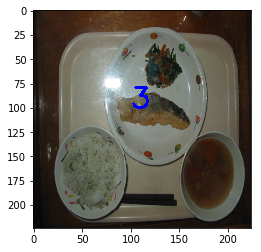

In [66]:
batches = CounterBatchGenerator(all_imgs, generator_config)
img = batches[0][0][0][1]
plt.imshow(img.astype('uint8'))

In [56]:
def normalize(image):
    return image / 255.

train_valid_split = int(0.8 * len(all_imgs))

train_batch = CounterBatchGenerator(all_imgs[:train_valid_split], generator_config, norm=normalize, jitter=False)
valid_batch = CounterBatchGenerator(all_imgs[train_valid_split:], generator_config, norm=normalize, jitter=False)

input_image = layers.Input(shape=(224, 224, 3))

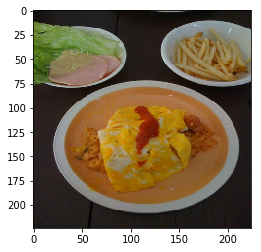

In [57]:
img = train_batch[0][0][0][1]
plt.imshow(img.astype('float'))  # beacuse of normalization

In [58]:
def build_model():
    print('=> Building CNN model for countering objects...')
    mobilenet = MobileNet(input_shape=(224, 224, 3), include_top=False)
    x = mobilenet(input_image)
    
    x = layers.Flatten()(x)
    x = layers.Dense(2048)(x)
    x = layers.Activation('relu')(x)
    x = layers.Dense(2048)(x)
    x = layers.Activation('relu')(x)
    x = layers.Dense(1, activation='softmax')(x)

#     x = layers.GlobalAveragePooling2D()(x)
#     x = layers.Dense(1, activation='softmax')(x)
    
    model = Model([input_image], x)
    return model

In [59]:
model = build_model()
model.summary()

=> Building CNN model for countering objects...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten_3 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 2048)              102762496 
_________________________________________________________________
activation_5 (Activation)    (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
activation_6 (Activation)   

In [60]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

def train():
    early_stop = EarlyStopping(monitor='val_loss',
                               min_delta=0.001,
                               patience=3,
                               mode='min',
                               verbose=1)

    checkpoint = ModelCheckpoint('food_counter.h5',
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='min',
                                 period=1)

    model.load_weights('./food_counter.h5') 

#     tb_counter = len([log for log in os.listdir(os.path.expanduser('./tl_tf_logs/')) if 'food' in log]) + 1
#     tensorboard = TensorBoard(log_dir=os.path.expanduser('~/mess/') + 'food_counter' + '_' + str(tb_counter),
#                               histogram_freq=0,
#                               write_graph=True,
#                               write_images=False)
    
    reduce_lr = ReduceLROnPlateau(patience=0, factor=0.2, monitor='val_loss', verbose=1)

    # TODO: try different optimizer and tweak parameters (in MN1 paper they used RMSprop)
    optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    # optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
    # optimizer = RMSprop(lr=1e-5, rho=0.9, epsilon=1e-08, decay=0.0)

    model.compile(loss='mse', optimizer=optimizer, metrics=['mean_absolute_error'])

    model.fit_generator(generator=train_batch,
                        steps_per_epoch=len(train_batch),
                        epochs=20,  # 100
                        verbose=1,
                        validation_data=valid_batch,
                        validation_steps=len(valid_batch),
                        callbacks=[early_stop, checkpoint, reduce_lr],
                        max_queue_size=3)

In [61]:
train()

Epoch 1/20
280/280 [==============================] - 45s 160ms/step - loss: 4.1420 - mean_absolute_error: 1.8062 - val_loss: 4.0768 - val_mean_absolute_error: 1.8232

Epoch 00001: val_loss improved from inf to 4.07679, saving model to food_counter.h5
Epoch 2/20
280/280 [==============================] - 27s 95ms/step - loss: 4.1455 - mean_absolute_error: 1.8071 - val_loss: 4.0768 - val_mean_absolute_error: 1.8232

Epoch 00002: val_loss did not improve from 4.07679

Epoch 00002: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 3/20
 14/280 [>.............................] - ETA: 22s - loss: 4.8125 - mean_absolute_error: 1.8304

KeyboardInterrupt: 